# TensorSensor

TensorSensor clarifies exceptions by augmenting messages and visualizing Python code to indicate the shape of tensor variables (see figure to the right for a teaser). It works with Tensorflow, PyTorch, JAX, and Numpy, as well as higher-level libraries like Keras and fastai.  Besides trapping exceptions, TensorSensor can provide visualizations of code that executes without exception. You can also see the complete expression tree computation and the shapes of self-expression partial results.

See article [Clarifying exceptions and visualizing tensor operations in deep learning code](https://explained.ai/tensor-sensor/index.html) at [explained.ai](https://explained.ai).

## Clarifying the cause of tensor exceptions

In [1]:
import sys

In [2]:
! pip install -q tensor-sensor

In [3]:
import tsensor
tsensor.__version__

'0.1.4'

### NumPy

In [4]:
import numpy as np

W = np.array([[1, 2], [3, 4]])
b = np.array([9, 10]).reshape(2, 1)
x = np.array([4, 5]).reshape(2, 1)
h = np.array([1,2])

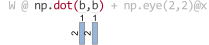

PyTorch says: shapes (2,1) and (2,1) not aligned: 1 (dim 1) != 2 (dim 0)

tsensor adds: Cause: np.dot(b,b) tensor arg b w/shape (2, 1), arg b w/shape (2, 1)


In [5]:
try: # try is used just to catch the exception and extract the messages
    with tsensor.clarify():
        W @ np.dot(b,b) + np.eye(2,2)@x
except BaseException as e:
    msgs = str(e).split("\n")
    sys.stderr.write("PyTorch says: "+msgs[0]+'\n\n')
    sys.stderr.write("tsensor adds: "+msgs[1]+'\n')

### PyTorch

In [6]:
import tsensor
import torch
import sys

W = torch.tensor([[1, 2], [3, 4]])
b = torch.tensor([9, 10]).reshape(2, 1)
x = torch.tensor([4, 5]).reshape(2, 1)
h = torch.tensor([1,2])

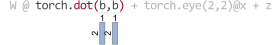

PyTorch says: 1D tensors expected, but got 2D and 2D tensors

tsensor adds: Cause: torch.dot(b,b) tensor arg b w/shape [2, 1], arg b w/shape [2, 1]


In [7]:
try: # try is used just to catch the exception and extract the messages
    with tsensor.clarify():
        W @ torch.dot(b,b) + torch.eye(2,2)@x + z
except BaseException as e:
    msgs = e.args[0].split("\n")
    sys.stderr.write("PyTorch says: "+msgs[0]+'\n\n')
    sys.stderr.write("tsensor adds: "+msgs[1]+'\n')

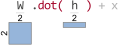

PyTorch says: 1D tensors expected, but got 2D and 1D tensors

tsensor adds: Cause: W.dot(h) tensor arg h w/shape [2]


In [8]:
try:
    with tsensor.clarify():
        W.dot(h) + x
except BaseException as e:
    msgs = e.args[0].split("\n")
    sys.stderr.write("PyTorch says: "+msgs[0]+'\n\n')
    sys.stderr.write("tsensor adds: "+msgs[1]+'\n')

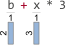

PyTorch says: The size of tensor a (2) must match the size of tensor b (3) at non-singleton dimension 0

tsensor adds: Cause: + on tensor operand b w/shape [2, 1] and operand x * 3 w/shape [3, 1]


In [9]:
x = torch.tensor([4, 5, 6]).reshape(3, 1)

try:
    with tsensor.clarify():
        b + x * 3
except BaseException as e:
    msgs = str(e).split("\n")
    sys.stderr.write("PyTorch says: "+msgs[0]+'\n\n')
    sys.stderr.write("tsensor adds: "+msgs[1]+'\n')

### TensorFlow

In [10]:
import tensorflow as tf

In [11]:
W = tf.constant([[1, 2], [3, 4]])
b = tf.reshape(tf.constant([[9, 10]]), (2, 1))
x = tf.reshape(tf.constant([[8, 5, 7]]), (3, 1))

2021-12-09 14:56:20.735167: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


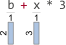

tensorflow says: Incompatible shapes: [2,1] vs. [3,1] [Op:AddV2]

tsensor adds: Cause: + on tensor operand b w/shape (2, 1) and operand x * 3 w/shape (3, 1)


In [12]:
try:
    with tsensor.clarify():
        res = x * 3
        res = tf.matmul(W, b)
        b + x * 3
except BaseException as e:
    msgs = str(e).split("\n")
    sys.stderr.write("tensorflow says: "+msgs[0]+'\n\n')
    sys.stderr.write("tsensor adds: "+msgs[1]+'\n')

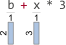

tensorflow says: Incompatible shapes: [2,1] vs. [3,1] [Op:AddV2]

tsensor adds: Cause: + on tensor operand b w/shape (2, 1) and operand x * 3 w/shape (3, 1)


In [13]:
def foo(): bar()
def bar():
    b + x * 3

try:
    with tsensor.clarify(): # works for any called functions too
        foo()
except BaseException as e:
    msgs = str(e).split("\n")
    sys.stderr.write("tensorflow says: "+msgs[0]+'\n\n')
    sys.stderr.write("tsensor adds: "+msgs[1]+'\n')

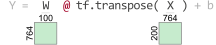

InvalidArgumentError: In[0] mismatch In[1] shape: 100 vs. 764: [764,100] [764,200] 0 0 [Op:MatMul]
Cause: @ on tensor operand W w/shape (764, 100) and operand tf.transpose(X) w/shape (764, 200)

In [14]:
import tensorflow as tf
n = 200         # number of instances
d = 764         # number of instance features
nhidden = 256
n_neurons = 100

W = tf.random.uniform((d,n_neurons))
b = tf.random.uniform((n_neurons,1))
X = tf.random.uniform((n,d))
with tsensor.clarify():
    Y = W @ tf.transpose(X) + b

### JAX

JAX actually gives very good shape messages but TensorSensor visualizes the specifics of expression with the problem.

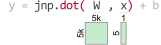

JAX says: Incompatible shapes for dot: got (5000, 5000) and (5, 1).

tsensor adds: Cause: jnp.dot(W, x) tensor arg W w/shape (5000, 5000), arg x w/shape (5, 1)


In [15]:
import jax.numpy as jnp
from jax import random

key = random.PRNGKey(0)

size = 5000
W = random.normal(key, shape=(size, size)).astype(jnp.float32)
x = random.normal(key, shape=(5, 1)).astype(jnp.float32)
x = random.normal(key, shape=(5, 1)).astype(jnp.float32)

try:
    with tsensor.clarify() as cl:
        y = jnp.dot(W, x) + b
except TypeError as e:
    msgs = str(e).split("\n")
    sys.stderr.write("JAX says: "+msgs[0]+'\n\n')
    sys.stderr.write("tsensor adds: "+msgs[1]+'\n')

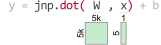

TypeError: Incompatible shapes for dot: got (5000, 5000) and (5, 1).
Cause: jnp.dot(W, x) tensor arg W w/shape (5000, 5000), arg x w/shape (5, 1)

In [16]:
with tsensor.clarify() as cl:
    y = jnp.dot(W, x) + b

## Explaining matrix algebra statements visually

In [17]:
W = torch.rand(size=(2000,2000))
b = torch.rand(size=(2000,1))
h = torch.rand(size=(1_000_000,))
x = torch.rand(size=(2000,1))

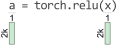

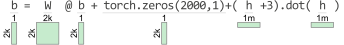

In [18]:
import tsensor
with tsensor.explain() as explained:
    a = torch.relu(x)
    b = W @ b + torch.zeros(2000,1)+(h+3).dot(h)

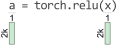

In [19]:
explained.views[0]

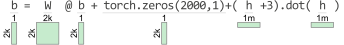

In [20]:
explained.views[1]

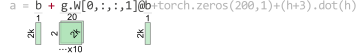

torch says: The size of tensor a (2000) must match the size of tensor b (20) at non-singleton dimension 0

torch adds: Cause: + on tensor operand b w/shape [2000, 1] and operand g.W[0,:,:,1]@b w/shape [20, 1]


In [21]:
class GRU: # fake random junk
    def __init__(self):
        self.W = torch.rand(size=(2,20,2000,10))
        self.b = torch.rand(size=(20,1))

# W = torch.tensor([[1, 2], [3, 4]])
b = torch.rand(size=(2000,1))
h = torch.rand(size=(1_000_000,2))

g = GRU()
try:
    with tsensor.explain():
        a = 3
        a = b + g.W[0,:,:,1]@b+torch.zeros(200,1)+(h+3).dot(h)
except BaseException as e:
    msgs = str(e).split("\n")
    sys.stderr.write("torch says: "+msgs[0]+'\n\n')
    sys.stderr.write("torch adds: "+msgs[1]+'\n')

In [ ]:
try:
    with tsensor.clarify():
        a = b + g.W[0,:,:,1]@b+torch.zeros(200,1)+(h+3).dot(h)
except BaseException as e:
    msgs = str(e).split("\n")
    sys.stderr.write("torch says: "+msgs[0]+'\n\n')
    sys.stderr.write("torch adds: "+msgs[1]+'\n')

In [ ]:
try:
    with tsensor.clarify():
        W @ np.dot(b, b) + np.eye(2, 2) @ x
except BaseException as e:
    msgs = str(e).split("\n")
    sys.stderr.write("torch says: "+msgs[0]+'\n\n')
    sys.stderr.write("torch adds: "+msgs[1]+'\n')

### Saving explanations to files

In [ ]:
W = torch.rand(size=(2000,2000))
b = torch.rand(size=(2000,1))
h = torch.rand(size=(1_000_000,))
x = torch.rand(size=(2000,1))

with tsensor.explain(savefig="/tmp/foo.svg"): # save foo-1.svg and foo-2.svg in /tmp
    a = torch.relu(x)
    b = W @ b + x * 3 + h.dot(h)

In [ ]:
!ls -l /tmp/foo-?.svg

In [ ]:
from IPython.display import SVG
display(SVG("/tmp/foo-2.svg"))

## Lower-level API to show abstract syntax trees (AST) and evaluate them

### Get ast and computation result

In [ ]:
root, result = tsensor.eval("W @ b + x * 3 + h.dot(h)")  # use current context to evaluate.
result

### Show the ast

In [ ]:
tsensor.astviz("q = W @ b + x * 3 + h.dot(h) + 4") # don't eval, just show AST

In [ ]:
g = tsensor.astviz("b = W@b + (h+3).dot(h) + torch.abs(torch.tensor(34))", sys._getframe()) # eval, highlight vectors
g

In [ ]:
g.savefig("/tmp/ast.svg")

In [ ]:
g.savefig("/tmp/ast.pdf")

In [ ]:
display(SVG("/tmp/ast.svg"))

### Show specific code w/o need of a `with` statement:

In [ ]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots(1,1)
tsensor.pyviz("W @ b + x * 3 + h.dot(h)", ax=ax)
plt.show()

In [ ]:
view = tsensor.pyviz("W @ b + x * 3 + h.dot(h)")
view.show()

### Greater than 2 dimensions

In [ ]:
n_batches, batch_size, d = 10, 100, 764
i = 2
X = torch.rand(n_batches, batch_size, d, 3)
with tsensor.explain():
    batch = X[i,:,:]

# PLAY

In [ ]:
W = torch.tensor([[1, 2], [3, 4]])
b = torch.tensor([9, 10], dtype=int).reshape(2, 1)
x = torch.tensor([4, 5]).reshape(2, 1)
h = torch.tensor([1,2])

with tsensor.clarify(legend=True):
    W @ torch.dot(b, b) + torch.eye(2, 2) @ x

In [ ]:
n_batches, batch_size, d = 10, 100, 764
i = 2
X = torch.rand(n_batches, batch_size, d, 3)
with tsensor.explain(legend=True):
    batch = X[i,:,:]

In [ ]:
blueish = '#3B75AF'
orangeish = '#EF8636'
greenish = '#519E3E'
orangeish = '#FDDB7D'

limeish = '#C1E1C5'
yellowish = '#FFFFD1'

ntypes = 3

import matplotlib.pyplot as plt
import matplotlib.colors as mc
# c = (limeish)
c = list(map(mc.hex2color, [orangeish, limeish, yellowish]))

c = np.array(c)
print(c)
plt.figure(figsize=(2,1))

alphas = np.linspace(0,1.0,nhues).reshape(-1,1)
print(alphas)

c = np.hstack([c, alphas])
print(c)

In [ ]:
c = np.array([*mc.hex2color(limeish), 1.0])
plt.scatter(np.arange(nhues), [1]*nhues, c=[c]*nhues, alpha=1.0)
c = np.array([*mc.hex2color(yellowish), 1.0])
plt.scatter(np.arange(nhues), [2]*nhues, c=[c]*nhues, alpha=1.0)
c = np.array([*mc.hex2color(orangeish), 1.0])
plt.scatter(np.arange(nhues), [3]*nhues, c=[c]*nhues)

plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
plt.get_cmap(cmap)(np.arange(4, dtype=int))

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mc

bits = [4,8,16,32,64,128]
nhues = len(bits)
plt.figure(figsize=(2,1))

for i in range(3):
    rgb = plt.get_cmap('tab10')(i)
    rgb = rgb[:3] # strip the alpha
    hsv = mc.rgb_to_hsv(rgb)
    print(hsv)
    hues = np.linspace(hsv,0.25,nhues)
    print(hues)
    hues = mc.hsv_to_rgb(hues)
    cmap = mc.ListedColormap(hues)
    plt.scatter(np.arange(nhues),[i]*nhues, c=np.arange(nhues), cmap=cmap, s=80)

plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mc

bits = [4,8,16,32,64,128]
nc = len(bits)
cmap="tab10"
ccolors = plt.get_cmap(cmap)(np.arange(nc, dtype=int))
print(ccolors)
for i, c in enumerate(ccolors):
    chsv = matplotlib.colors.rgb_to_hsv(c[:3])
    arhsv[:,1] = np.linspace(chsv[1],0.25,nsc)
    arhsv[:,2] = np.linspace(chsv[2],1,nsc)
    rgb = matplotlib.colors.hsv_to_rgb(arhsv)
    print(rgb)

In [ ]:
import matplotlib.colors as mc
import colorsys

c = mc.cnames['navy']
rgb = mc.ColorConverter.to_rgb(c)

In [ ]:
#rgb = mc.ColorConverter.to_rgb("#ff0000")

In [ ]:
h, l, s = colorsys.rgb_to_hls(*rgb)
for scale_l in [0,.3,.5,1]:
    print(colorsys.hls_to_rgb(h, min(1, l * scale_l), s = s))

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mc
%config InlineBackend.figure_format = 'svg'



ntypes = 3

def get_alpha_shades(color, n=5, alpha_range = (0.1,1.0)):
    """
    For a given color name or '#hex' rgb string, return a matrix with
    n RGB+alpha rows. The alpha range is split into n values.  E.g.,
    get_alpha_shades('#A8E1B0', n=5) returns:    
    
    [[0.65882353 0.88235294 0.69019608 0.1       ]
     [0.65882353 0.88235294 0.69019608 0.325     ]
     [0.65882353 0.88235294 0.69019608 0.55      ]
     [0.65882353 0.88235294 0.69019608 0.775     ]
     [0.65882353 0.88235294 0.69019608 1.        ]]    
    """
    if color[0]!='#':
        color = mc.cnames[color]
    color = mc.hex2color(color) if color[0]=='#' else mc.cnames[color]
    colors = np.array([color]*n)
    alphas = np.linspace(*alpha_range,n).reshape(-1,1)
    colors = np.hstack([colors, alphas])
    return colors

In [ ]:
orangeish = '#FDDB7D'
orangeish = '#FDD66C'
limeish = '#C1E1C5'
limeish = '#A8E1B0'
yellowish = '#FFFFD1'
yellowish = '#FFFFAD'
blueish = '#7FA4D3'

bits = [4, 8,16,32,64,128]
bits = [32,64,128]
bits = [8,16,32,64,128]
nc = len(bits)

plt.figure(figsize=(3,3))

c = get_alpha_shades(limeish, n=nc)
plt.scatter(np.arange(nc), [1]*nc, c=c, s=1350, linewidths=.5, edgecolors='grey')
c = get_alpha_shades(orangeish, n=nc)
plt.scatter(np.arange(nc), [2]*nc, c=c, s=1350, linewidths=.5, edgecolors='grey')
c = get_alpha_shades(blueish, n=nc)
plt.scatter(np.arange(nc), [3]*nc, c=c, s=1350, linewidths=.5, edgecolors='grey')

plt.ylim(0,4)
plt.xlim(-1,nc-1)
plt.axis('off')
plt.tight_layout()
plt.show()